# RowDecoder 2x

After exploring the RowDecoder 1x, we can now explore the RowDecoder 2x. From now on, only the fanIn-2 cells are considered

In [1]:
from circuit import *
from optimum_sizing import *
from metal import *

# Library needed to print with the "Engineering Notation" the results
from quantiphy import Quantity

#### Some constant definitions

In [2]:
TAU_1 = 6.18e-12                                    # Intrinsic delay of the inverter (s)
TAU_2 = 3.717e-12                                   # Effort delay of the inverter (s)
TAU_RATIO = TAU_1 / TAU_2                           # Tau ratio

BETA_OPT = 2.5                                      # Beta factor
BETA_FIRST = 2                                      # Beta factor first buffer
C_INT_TRANS = 0.5e-15 / (BETA_OPT + 1)              # Intrinsic capacitance of the transistor (F)
C_GATE_INV = C_INT_TRANS * (BETA_OPT + 1)           # Gate capacitance of the inverter (F)
S_WIRE = 0.1                                        # Minimum distance between wires (um)
W_WIRE_STANDARD = 0.1                               # Standard width of the wire (um)

L_BITCELL = 1                                       # length of the cell (um)              
W_BITCELL = 0.5                                     # height of the cell (um)

WORD_SIZE = 32
ADDRESS_NB = 256

WL_LENGTH = WORD_SIZE * L_BITCELL
PRE2POST_DECODER_LENGTH = ADDRESS_NB * W_BITCELL

BITCELL_CAP = 2 * WORD_SIZE * C_INT_TRANS           # Input cap of the whole

#### Some metal definitions

In [3]:
# Dummy metal (0 resistance, 0 capacitance)
DUMMY_METAL = Metal("dummy_metal", 0, 0.0001, 0, S_WIRE, 1)

# Metal from pre-decoder to post-decoder without buffers
pre_post_metal = Metal("pre_post_metal", 2, W_WIRE_STANDARD, PRE2POST_DECODER_LENGTH, S_WIRE, False)

# Metal from post-decoder to WL
post_WL_metal = Metal("post_WL_metal", 3, W_WIRE_STANDARD, WL_LENGTH, W_BITCELL, True)

## Architecture
The architecture we are exploring is the following one\
\
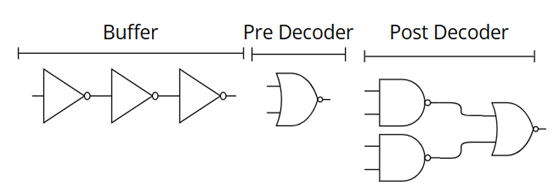
#### Define the FanIn/FanOut of the different stages

In [4]:
group = 2                                # Number of bits per group 

# Define some useful variables
DRIVER_FO  = np.power(2,(group-1))       # Fan-out of the input driver
PREDEC_FI  = group                       # Fan-in of the predecoder gate
PREDEC_FO  = np.power(2, (8 - group))    # Pre-decored fan-out
POSTDEC_FI = 8//group                    # Post-decoder fan-in

POSTDEC_FI_ARCH1 = 2

#### Define all the gates of this architecture

In [5]:
input_buffer = Inverter("input_buffer", BETA_FIRST, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

nor_branch_list_pre = list()
for i in range(DRIVER_FO):
    nor_2x_preDec = Nor("nor_2x_pre_" + str(i), BETA_OPT, BETA_OPT, 1, PREDEC_FI, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nor_branch_list_pre.append(nor_2x_preDec)

nor_branch_pre = Branch("nor_pre", nor_branch_list_pre)

# PP_wire = Wire("pre_post_wire", BETA_OPT, BETA_OPT, 1, pre_post_metal, C_INT_TRANS, TAU_RATIO)

nand_branch_list_post = list()
for i in range(PREDEC_FO):
    nand_2x_postDec =  Nand("nand_2x_post_" + str(i), BETA_OPT, BETA_OPT, 1, POSTDEC_FI_ARCH1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_branch_list_post.append(nand_2x_postDec)

nand_branch_post = Branch("nand_post", nand_branch_list_post)
nor_post = Nor("nor_post", BETA_OPT, BETA_OPT, 1, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

#### Optimal number of buffers

In [6]:
row_2x_gates_no_buff = [input_buffer, nor_branch_pre, nand_branch_post, nor_post]
row_2x_no_buff = Circuit("RowDecoder 2x - no buffers", row_2x_gates_no_buff, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)

optimal_nb_buffer(nor_branch_pre.C_off + input_buffer.C_load, input_buffer.C_in_gate, TAU_RATIO)

Optimal stages number (rho = 3.59) = 0.9637683643784103
the delay is expressed in multiples of TAU_2 and it's only related to the buffers
	 -> delay (exact) = 5.063400579859174
	 -> delay (N = 1) = 5.091202582728006

Optimal stages number (rho = 4) = 0.8888037893317762
	 -> delay (exact) = 5.032968027402535
	 -> delay (N = 1) = 5.091202582728006

Upper even N = 2
	 -> delay = 7.028542707403362

Lower even N = 0
	0 stages does not make sense


For us, the buffers are inverters. So the optimal number is 2

#### Generate the circuit

In [7]:
# Complete circuit
buffer1 = Inverter("buffer1", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer2 = Inverter("buffer2", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

row_2x_gates = [input_buffer, buffer1, buffer2, nor_branch_pre, nand_branch_post, nor_post]
row_2x = Circuit("RowDecoder 2x", row_2x_gates, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
row_2x.info()

Circuit name: RowDecoder 2x
╒════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═════════════╤════════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ nor_pre   │ nand_post   │ nor_post   │
╞════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═════════════╪════════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 2.000     │ 2.000       │ 2.000      │
├────────────┼────────────────┼───────────┼───────────┼───────────┼─────────────┼────────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.714     │ 1.286       │ 1.714      │
├────────────┼────────────────┼───────────┼───────────┼───────────┼─────────────┼────────────┤
│ h          │ 1.000          │ 1.000     │ 1.714     │ 0.750     │ 1.333       │ 12.705     │
├────────────┼────────────────┼───────────┼───────────┼───────────┼─────────────┼────────────┤
│ b          │ 1.000          │ 1.000     │ 2.000     │ 64.000    │ 1.000       │ 1.000      │
├────────────┼────────

#### Optimize the size of the circuit

In [8]:
row_2x_opt = optimize_circuit_size(row_2x)
row_2x_opt.info()

Circuit name: RowDecoder 2x_optimized
╒════════════╤════════════════════╤═══════════════╤═══════════════╤═══════════════╤═════════════════╤════════════════╕
│            │ input_buffer_opt   │ buffer1_opt   │ buffer2_opt   │ nor_pre_opt   │ nand_post_opt   │ nor_post_opt   │
╞════════════╪════════════════════╪═══════════════╪═══════════════╪═══════════════╪═════════════════╪════════════════╡
│ p          │ 1.000              │ 1.000         │ 1.000         │ 2.000         │ 2.000           │ 2.000          │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┼─────────────────┼────────────────┤
│ g          │ 1.000              │ 1.000         │ 1.000         │ 1.714         │ 1.286           │ 1.714          │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┼─────────────────┼────────────────┤
│ h          │ 4.682              │ 4.682         │ 2.341         │ 0.043         │ 3.642           │ 2.731          │
├─────────

#### Add the wire by increasing the fanout of the nor of the predecoder to achieve a Coff = Coff_branch + Cwire

In [9]:
GAMMA_NAND_POST = 2
GAMMA_NOR_POST = 5

In [10]:
# Real size nand
nand = Nand("nand", BETA_OPT, BETA_OPT, 2, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

additional_FO = round(pre_post_metal.Ctot / nand.C_in_gate)
print(f"Additional Nand FanOut = {additional_FO}")

Additional Nand FanOut = 30


#### Create the final gates of the postdecoder

In [11]:
nand_branch_with_wire = list()
for i in range(PREDEC_FO + additional_FO):
    nand_2x_postDec =  Nand("nand_2x_post_" + str(i), BETA_OPT, BETA_OPT, GAMMA_NAND_POST, POSTDEC_FI_ARCH1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_branch_with_wire.append(nand_2x_postDec)

nand_branch_wire = Branch("nand_post", nand_branch_with_wire)

nor_final = Nor("nor_post", BETA_OPT, BETA_OPT, GAMMA_NOR_POST, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

#### Create the circuit for the predecoder

In [12]:
predec_gates = [input_buffer, buffer1, buffer2, nor_branch_pre]
predec = Circuit("RowDecoder 2x - PreDecoder", predec_gates, TAU_2, TAU_RATIO, (nand_branch_wire.C_in_gate + nand_branch_wire.C_off) / C_GATE_INV)
predec.info()

Circuit name: RowDecoder 2x - PreDecoder
╒════════════╤════════════════╤═══════════╤═══════════╤═══════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ nor_pre   │
╞════════════╪════════════════╪═══════════╪═══════════╪═══════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 2.000     │
├────────────┼────────────────┼───────────┼───────────┼───────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.714     │
├────────────┼────────────────┼───────────┼───────────┼───────────┤
│ h          │ 1.000          │ 1.000     │ 1.714     │ 141.000   │
├────────────┼────────────────┼───────────┼───────────┼───────────┤
│ b          │ 1.000          │ 1.000     │ 2.000     │ 64.000    │
├────────────┼────────────────┼───────────┼───────────┼───────────┤
│ gamma      │ 1.000          │ 1.000     │ 1.000     │ 1.000     │
├────────────┼────────────────┼───────────┼───────────┼───────────┤
│ Cin        │ 500 aF         │ 500 aF    │ 500 aF    │ 857.14 aF │
├──────

#### Optimize the predecoder

In [13]:
predec_opt = optimize_circuit_size(predec)
predec_opt.info()

Circuit name: RowDecoder 2x - PreDecoder_optimized
╒════════════╤════════════════════╤═══════════════╤═══════════════╤═══════════════╕
│            │ input_buffer_opt   │ buffer1_opt   │ buffer2_opt   │ nor_pre_opt   │
╞════════════╪════════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ p          │ 1.000              │ 1.000         │ 1.000         │ 2.000         │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┤
│ g          │ 1.000              │ 1.000         │ 1.000         │ 1.714         │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┤
│ h          │ 5.365              │ 5.365         │ 2.683         │ 3.130         │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┤
│ b          │ 1.000              │ 1.000         │ 2.000         │ 1.000         │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┤
│ gamma      │ 1.000     

#### Create the final RowDecoder circuit

In [14]:
GAMMA_BUFFER_1 = 5
GAMMA_BUFFER_2 = 29
GAMMA_NOR_BRANCH = 45

In [15]:
buffer1_final = Inverter("buffer1", BETA_OPT, BETA_OPT, GAMMA_BUFFER_1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer2_final = Inverter("buffer2", BETA_OPT, BETA_OPT, GAMMA_BUFFER_2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

nor_branch_final_list = list()
for i in range(DRIVER_FO):
    nor_2x_preDec = Nor("nor_2x_pre_" + str(i), BETA_OPT, BETA_OPT, GAMMA_NOR_BRANCH, PREDEC_FI, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nor_branch_final_list.append(nor_2x_preDec)

nor_branch_final = Branch("nor_pre", nor_branch_final_list)

rowdec_2x_final_gates = [input_buffer, buffer1_final, buffer2_final, nor_branch_final, nand_branch_wire, nor_final]
rowdec_2x_final = Circuit("RowDecoder 2x - Final Architecture", rowdec_2x_final_gates, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
rowdec_2x_final.info()

Circuit name: RowDecoder 2x - Final Architecture
╒════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═════════════╤════════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ nor_pre   │ nand_post   │ nor_post   │
╞════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═════════════╪════════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 2.000     │ 2.000       │ 2.000      │
├────────────┼────────────────┼───────────┼───────────┼───────────┼─────────────┼────────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.714     │ 1.286       │ 1.714      │
├────────────┼────────────────┼───────────┼───────────┼───────────┼─────────────┼────────────┤
│ h          │ 5.000          │ 5.800     │ 2.660     │ 0.033     │ 3.333       │ 2.541      │
├────────────┼────────────────┼───────────┼───────────┼───────────┼─────────────┼────────────┤
│ b          │ 1.000          │ 1.000     │ 2.000     │ 94.000    │ 1.000       │ 1.000      │
├

The final configuration of the RowDecoder is the following\
\
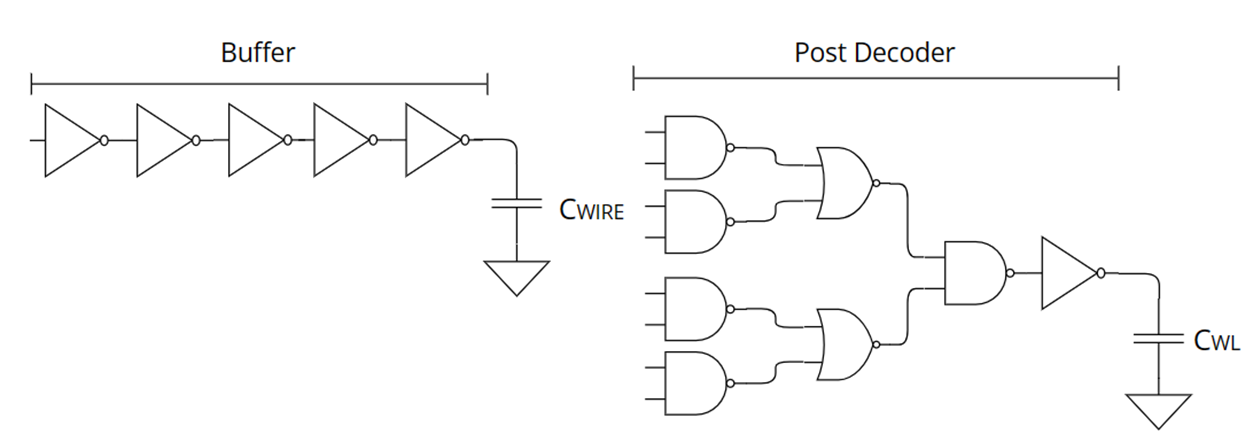

The total delay is

In [16]:
total_delay = rowdec_2x_final.delay + pre_post_metal.tau + post_WL_metal.tau
print(f"Total delay = {str(Quantity(total_delay, 's'))}")

Total delay = 169.41 ps
